# Differential Intelligence - Vectorised Duals

(original by Dario Izzo - extended by Ekin Ozturk)

In this notebook we show the use of `desolver` and vectorised gduals for the numerical integration of multiple initial conditions following the notebook example here [differential intelligence](https://darioizzo.github.io/audi/notebooks/example10.html).

## Importing Stuff

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import os
import numpy as np

os.environ['DES_BACKEND'] = 'numpy'
import desolver as de
import desolver.backend as D

D.set_float_fmt('gdual_vdouble')

PyAudi backend is available.
Using numpy backend


## Controller representation and “simulator”

Take as an example the task of learning a robotic controller. In neuro evolution (or Evolutionary Robotics), the controller is typically represented by a neural network, but for the purpose of explaining this new learning concept we will use a polinomial representation for the controller. Later, changing the controller into a NN with weights as parameters will not change the essence of what is done here.

In [2]:
# Definition of the controller in terms of some weights parameters
def u(state, weights):
    x,v = state
    a,b,c,e,f,g = weights
    return a + b*x + c*v + e*x*v + f*x**2 + g*v**2

In [3]:
# Definition of the equation of motion (our physics simulator propagating the system to its next state)
def eom(state, weights):
    x,v = state
    dx = v
    dv = u(state, weights)
    return (dx, dv)

## Numerical Integration - Runge-Kutta 45 Cash-Karp Method

In Evolutionary Robotics, Euler propagators are commonly used, but we would like to use a higher order integration scheme that is adaptive in order to minimise computation, and increase the accuracy and precision of the results.

We are using `gdual_vdouble` in order to integrate multiple initial states simultaneously without any significant loss of computation time due to the very efficient vectorisation of `gdual_vdouble` computations.

In [4]:
num_different_integrations = 16
weights = D.array([D.gdual_vdouble([0.2*(np.random.uniform()-0.5)]*num_different_integrations, _, 4) for _ in "abcefg"])
x = [D.gdual_vdouble([2.*(np.random.uniform()-0.5) for i in range(num_different_integrations)])]
v = [D.gdual_vdouble([2.*(np.random.uniform()-0.5) for i in range(num_different_integrations)])]
y0 = D.array(x + v, dtype=D.gdual_vdouble)

In [5]:
def rhs(t, state, weights, **kwargs):
    return D.array(eom(state, weights))

We integrate the system using the Runge-Kutta-Cash-Karp scheme as the numerical integration system with a dense output computed using a piecewise C1 Hermite interpolating spline. 

This particular interpolator is used as it satisfies not only the state boundary conditions, but also the gradients and is well suited for approximating the solution continuously up to first order in time.

Note that the entire integration is done using gduals and thus the solution and the interpolating spline stored in the OdeSystem instance, `pyaudi_integration`, contains all the information about how the state reached by our robot changes when we change the control weights.

In [6]:
# We restrict the integration time due to the fact that the controller 
# is quadratic in the state and causes the state to grow very rapidly.

pyaudi_integration = de.OdeSystem(rhs, y0=y0, dense_output=True, t=(0, 3.), dt=0.1, rtol=1e-12, atol=1e-12, constants=dict(weights=weights))

pyaudi_integration.set_method("RK45")
pyaudi_integration.integrate(eta=True)

x,v = pyaudi_integration.sol(D.linspace(0, 1, 20)).T

We numerically integrate 16 initial states and see the paths they follow based on the controller we have defined.

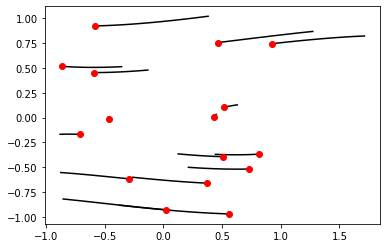

In [7]:
for _x, _v in zip(D.to_float(x).T, D.to_float(v).T):
    plt.plot(_x, _v, 'k')
plt.plot(x[0].constant_cf, v[0].constant_cf, 'ro')
plt.show()

In [8]:
xf, vf = x[-1], v[-1]

In [9]:
print("initial xf: {}".format(xf.constant_cf))
print("initial vf: {}".format(vf.constant_cf))

initial xf: [-0.3557066099106508, 0.44343882132762114, -0.8737317576067235, -0.2617441190669201, -0.8796623090368102, 0.3814675250018374, 0.4496686004618328, -0.13184594443243638, -0.8531865179643819, 0.6296049480439482, 1.272489314100466, -0.37367300287583055, 0.21369263660756216, -0.4685920682632495, 0.12662167090356946, 1.7123448444138816]
initial vf: [0.5118610410272438, -0.3701236243745896, -0.5532466100960509, -0.6008338241266351, -0.16869925311896916, 1.0191355842763685, 0.03313073890800292, 0.47769851923104645, -0.8193041150168822, 0.12783245934453705, 0.8664324532172547, -0.8819129622656402, -0.5007364437236071, 0.00378088557268934, -0.36570546484320804, 0.8206755520959318]


## Studying the effects of the weights on the behavior

We have represented all the robot behavior (x, v) as a polynomial function of the weights. So we now know what happens to the behaviour if we change the weights!! Lets see … we only consider the final state, but the same can be done for all states before.

Furthermore, we can compute this for all the different initial states that we integrated thus finding out how the final state of the robot changes for multiple initial conditions. 

In [10]:
dweights = dict({'da': -0.002, 'db': 0.003, 'dc': -0.02, 'de': 0.03, 'df': 0.02, 'dg': -0.01})
#Lets predict the new final position of our 'robot' if we change his controller as defined above
print("new xf: {}".format(xf.evaluate(dweights)))
print("new vf: {}".format(vf.evaluate(dweights)))

new xf: [-0.3644798190145982, 0.447495385967943, -0.8648361515237677, -0.2592939994695151, -0.8727114343058243, 0.3628173608150842, 0.4511668988597944, -0.14014616132168833, -0.8452539766438874, 0.632267395802166, 1.2758792802868362, -0.3718043764184628, 0.21623106958504587, -0.4679969881995721, 0.12859034018369273, 1.7319060943023437]
new vf: [0.4936346648964618, -0.36314723947811245, -0.5327100009566508, -0.5946732215257815, -0.15413715024294478, 0.9842045102773821, 0.0361826243667708, 0.4608953840430959, -0.7987016506520095, 0.13376814463127482, 0.8819766632015573, -0.8750423106238954, -0.49627765398605556, 0.004878367143968462, -0.36209906157800886, 0.8727946071182053]


## Check that we learned the correct map

We now simulate again our behavior using the new weights to see where we end up to check if the prediction made after our differential learning is correct.

In [11]:
new_weights = D.array([it + dweights['d' + it.symbol_set[0]] for it in weights])

In [12]:
pyaudi_integration2 = de.OdeSystem(rhs, y0=y0, dense_output=True, t=(pyaudi_integration.t[0], pyaudi_integration.t[-1]), dt=0.1, rtol=1e-12, atol=1e-12, constants=dict(weights=new_weights))

pyaudi_integration2.set_method("RK45")
pyaudi_integration2.integrate(eta=True)

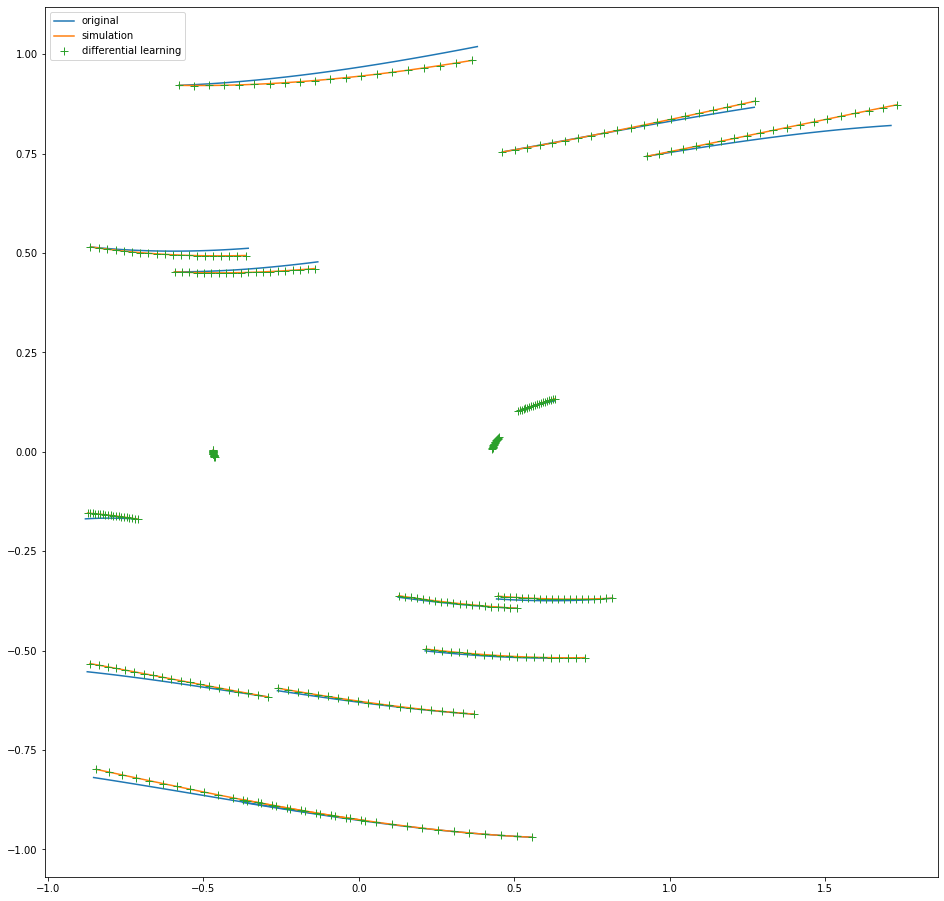

In [13]:
plt.figure(figsize=(16,16))
x2, v2 = pyaudi_integration2.sol(D.linspace(0, 1, 20)).T
for idx, (_x, _v) in enumerate(zip(D.to_float(x).T, D.to_float(v).T)):
    if idx == 0:
        plt.plot(_x,_v,'C0',label='original')
    else:
        plt.plot(_x,_v,'C0')
for idx, (_x, _v) in enumerate(zip(D.to_float(x2).T, D.to_float(v2).T)):
    if idx == 0:
        plt.plot(_x,_v,'C1',label='simulation')
    else:
        plt.plot(_x,_v,'C1')
for idx, (_x, _v) in enumerate(zip(D.array([it.evaluate(dweights) for it in x]).T,D.array([it.evaluate(dweights) for it in v]).T)):
    if idx == 0:
        plt.plot(_x,_v,'C2+', markersize=8.,label='differential learning')
    else:
        plt.plot(_x,_v,'C2+', markersize=8.)
# plt.plot(x[0].constant_cf, v[0].constant_cf, 'ro')
plt.legend(loc=2)
plt.show()

Since we have integrated multiple trajectories, printing all the final states and comparing it to the evaluated polynomial is visually difficult to parse. Instead, we look at the maximum and mean absolute differences between the numerical integration and the map evaluated with the new weights.

In [14]:
print("Maximum Absolute Difference xf:\t{}".format(D.max(D.abs(D.to_float(x2[-1]) - D.to_float(x[-1].evaluate(dweights))))))
print("Mean Absolute Difference xf:   \t{}".format(D.mean(D.abs(D.to_float(x2[-1]) - D.to_float(x[-1].evaluate(dweights))))))
print()
print("Maximum Absolute Difference vf:\t{}".format(D.max(D.abs(D.to_float(v2[-1]) - D.to_float(v[-1].evaluate(dweights))))))
print("Mean Absolute Difference vf:   \t{}".format(D.mean(D.abs(D.to_float(v2[-1]) - D.to_float(v[-1].evaluate(dweights))))))

Maximum Absolute Difference xf:	3.121884417645049e-10
Mean Absolute Difference xf:   	4.664606374771285e-11

Maximum Absolute Difference vf:	9.84426262728988e-10
Mean Absolute Difference vf:   	1.7914556643683355e-10
